In [1]:
import decoupler as dc
import pandas as pd
import os
import anndata as ad
import scanpy as sc
import numpy as np
import mygene
import seaborn as sns
import pickle as pkl
from scipy.sparse import csr_matrix

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
sc.set_figure_params(dpi=100)

import liana as ln

In [2]:
train_cluster = pd.read_csv("../../../../data/expression/processed/train/V4/IO-Atlas-NSCLC-CLUSTERS-TRAIN-2023-08-10-V4.tsv",
                            sep='\t', header=None)

test_cluster = pd.read_csv("../../../../data/expression/processed/test/V4/IO-Atlas-NSCLC-CLUSTERS-TEST-2023-08-10-V4.tsv",
                            sep='\t', header=None)

In [3]:
clusters = pd.concat((train_cluster, test_cluster))

In [4]:
response_clusters = clusters[clusters[1].str.contains("Response")]
resistant_clusters = clusters[clusters[1].str.contains("Resistant")]

In [5]:
#
# Train
#
trainX = pd.read_csv("../../../../data/enrichment/IO-Atlas-NSCLC-TPM-MinMaxNorm-TRAIN-2023-08-10-V4-response-subtype-clusters.tsv",
                         sep='\t')

trainX.index = [x.replace('.', '-') for x in trainX.index.values]

trainY = pd.read_csv("../../../../data/expression/processed/train/V4/IO-Atlas-NSCLC-LABEL-TRAIN-2023-08-10-V4.tsv",
                    sep='\t',
                    index_col=0,
                    header=None)

trainX = trainX.reindex(trainY.index)

#
# Test
#
testX = pd.read_csv("../../../../data/enrichment/IO-Atlas-NSCLC-TPM-MinMaxNorm-TEST-2023-08-10-V4-response-subtype-clusters.tsv",
                         sep='\t')

testX.index = [x.replace('.', '-') for x in testX.index.values]

testY = pd.read_csv("../../../../data/expression/processed/test/V4/IO-Atlas-NSCLC-LABEL-TEST-2023-08-10-V4.tsv",
                    sep='\t',
                    index_col=0,
                    header=None)

testX = testX.reindex(testY.index)

testX.columns = trainX.columns

In [6]:
msigdb = dc.get_resource(name='MSigDB')

print("\n".join(list(msigdb["collection"].unique())))

# Filter by hallmark
msigdb = msigdb[msigdb['collection'].isin(["reactome_pathways", "hallmark", "go_biological_process"])]

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

msigdb["source"] = msigdb["geneset"]
msigdb["target"] = msigdb["genesymbol"]
msigdb["weight"] = 1.0

INFO:root:Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/about?format=text`
INFO:root:Downloading annotations for all proteins from the following resources: `['MSigDB']`


chemical_and_genetic_perturbations
immunesigdb
mirna_targets_mirdb
go_molecular_function
tf_targets_gtrf
tf_targets_legacy
oncogenic_signatures
cell_type_signatures
vaccine_response
go_biological_process
cancer_gene_neighborhoods
cancer_modules
go_cellular_component
wikipathways
reactome_pathways
hallmark
mirna_targets_legacy
biocarta_pathways
positional
human_phenotype_ontology
pid_pathways
kegg_pathways


In [7]:
import scanpy as sc

gmap = sc.queries.biomart_annotations("hsapiens",
        ["ensembl_gene_id", "external_gene_name"],
    ).set_index("ensembl_gene_id")

# Retrieve DoRothEA gene regulatory network
dorothea = dc.get_dorothea(organism='human')

# Progeny
progeny = dc.get_progeny(organism='human', top=500)

counts = pd.read_csv("../../../../data/expression/original/SU2C-MARK_Harmonized_rnaseqc_counts_v1.gct",
                     sep='\t', 
                     header=2)

counts["Name"] = [x.split(".")[0] for x in counts["Name"].values]

counts = counts.groupby("Name").sum()

counts = counts.drop("Description", axis=1)

INFO:root:Downloading annotations for all proteins from the following resources: `['PROGENy']`


In [8]:
trainX.index.intersection(testX.index)

Index([], dtype='object', name=0)

In [9]:
enrich = pd.concat([trainX, testX], axis=0, join="inner")

NSCLC-Response-Cluster-0


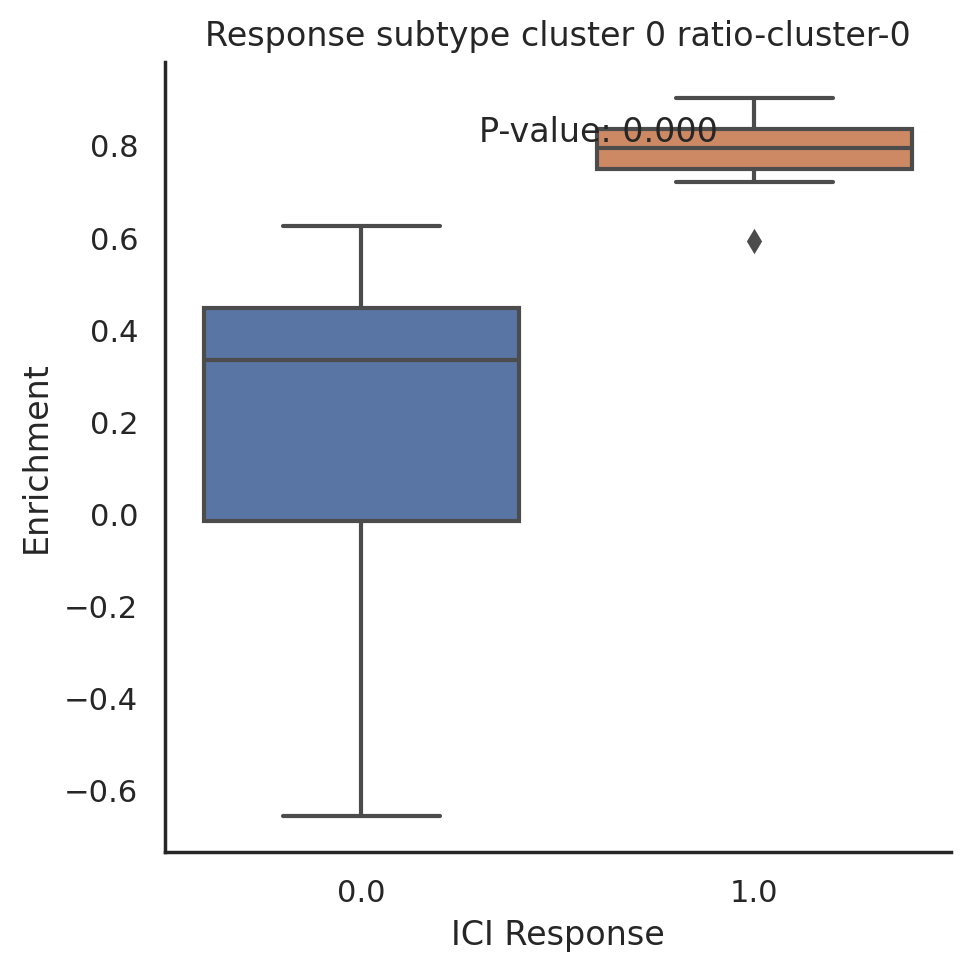

<Figure size 400x400 with 0 Axes>

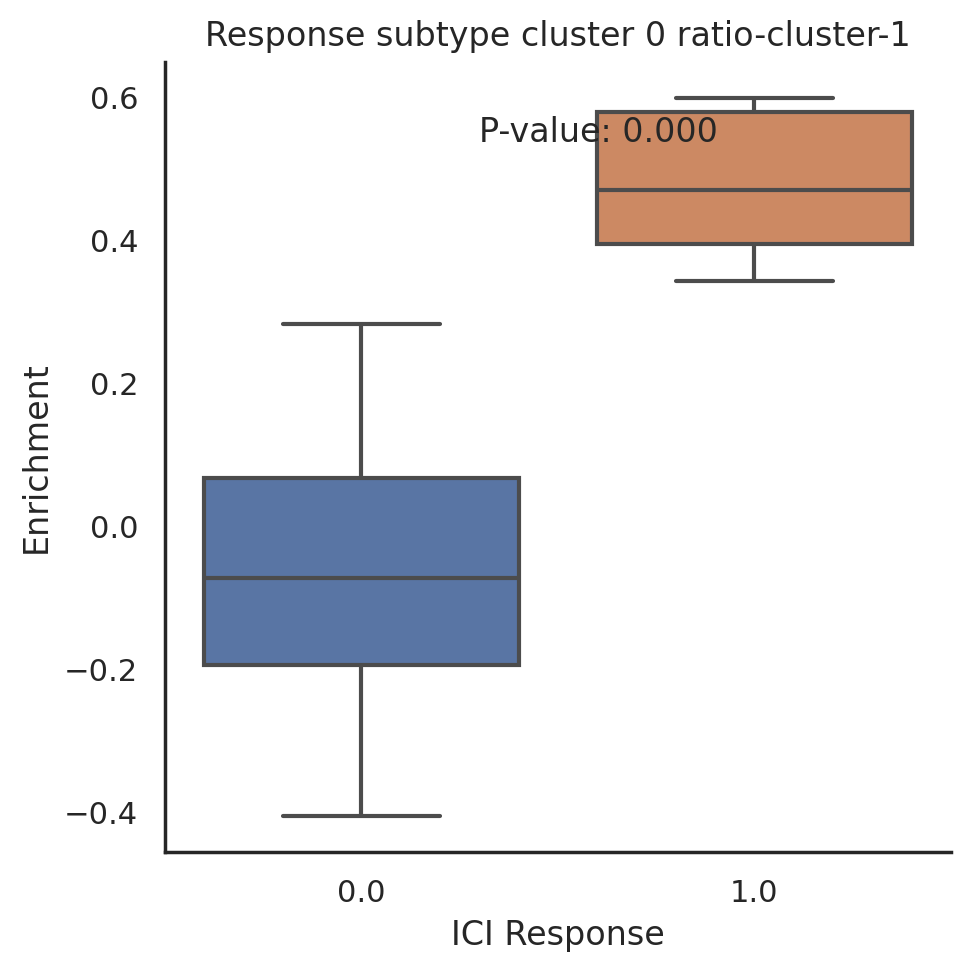

NSCLC-Response-Cluster-1


<Figure size 400x400 with 0 Axes>

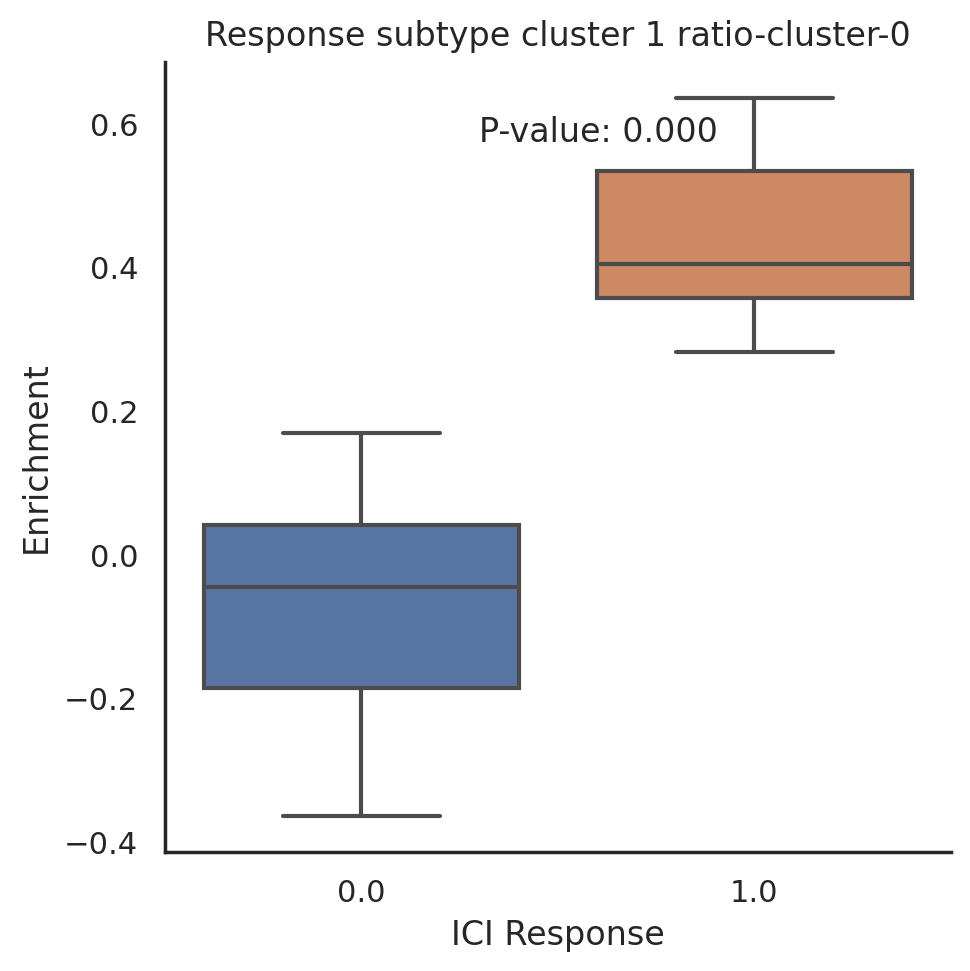

<Figure size 400x400 with 0 Axes>

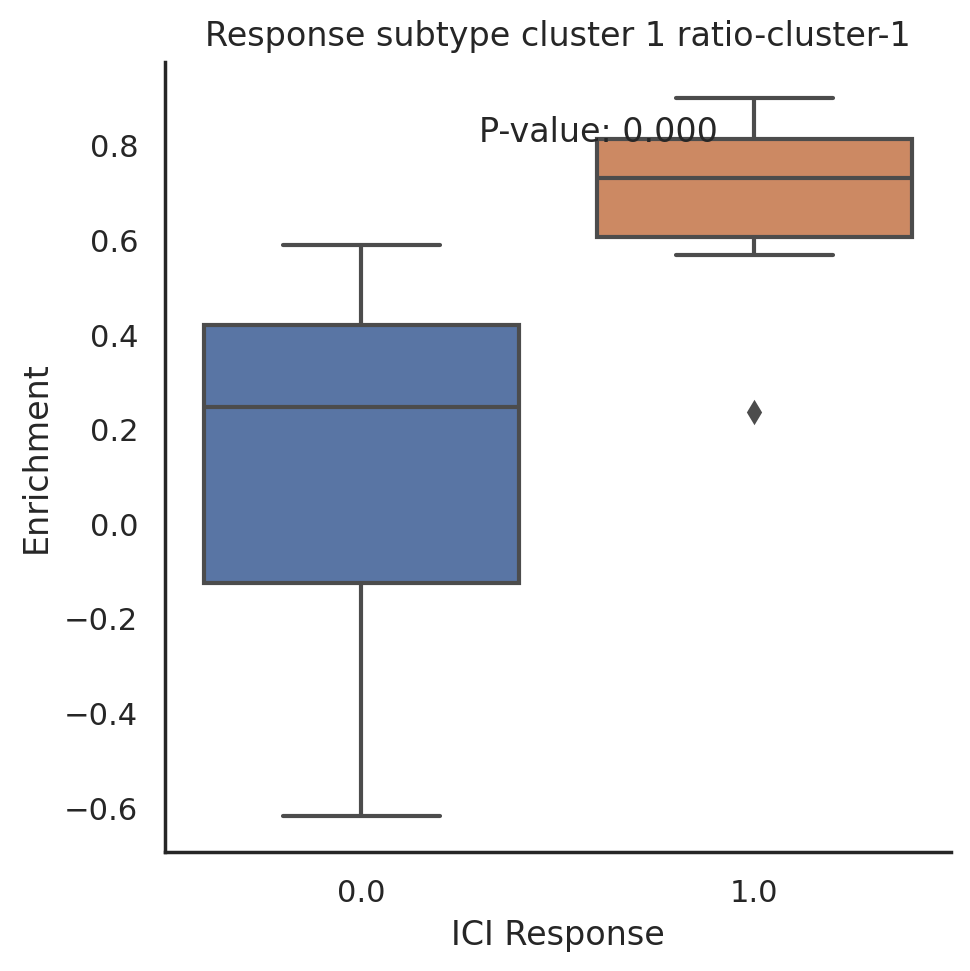

<Figure size 400x400 with 0 Axes>

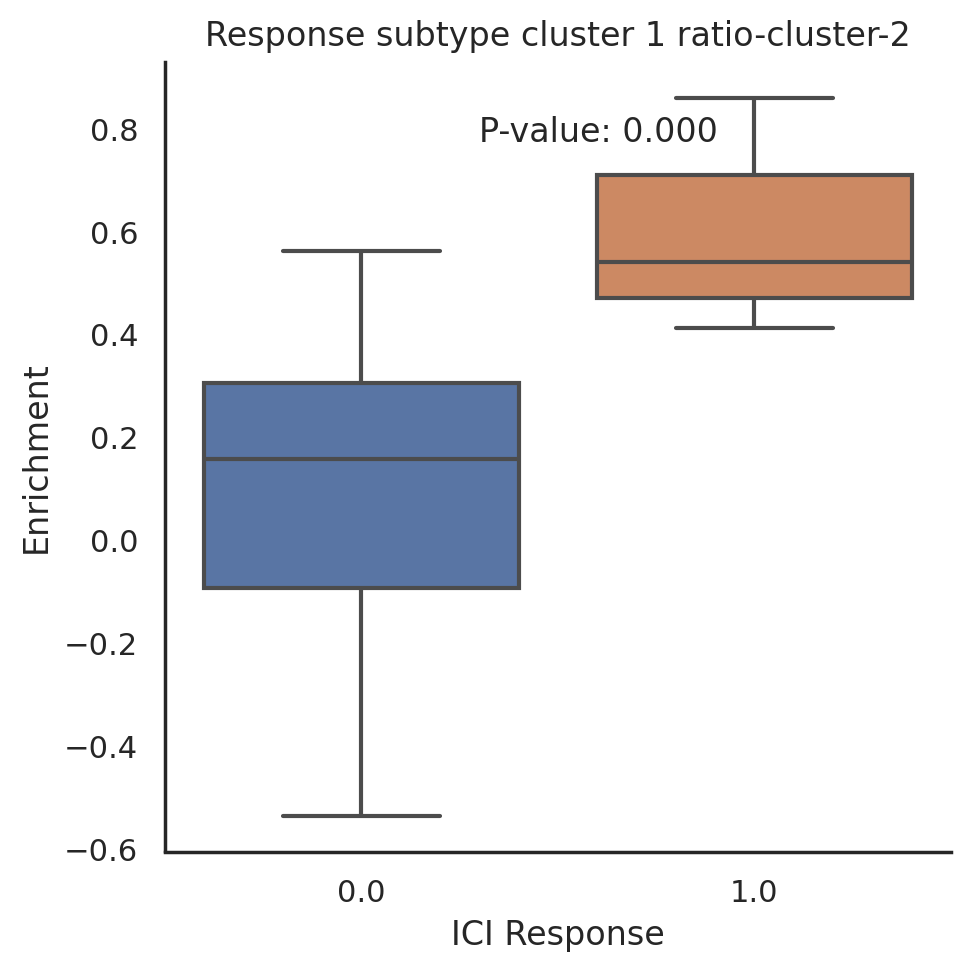

NSCLC-Response-Cluster-2


<Figure size 400x400 with 0 Axes>

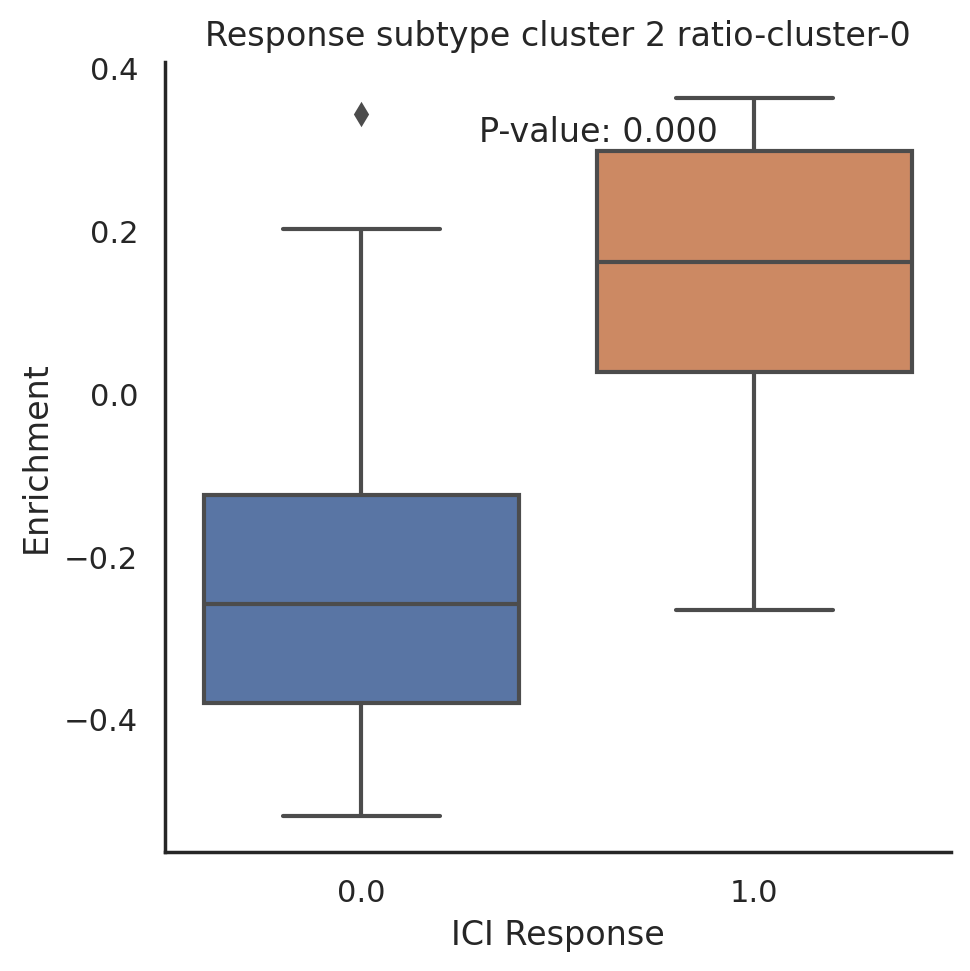

<Figure size 400x400 with 0 Axes>

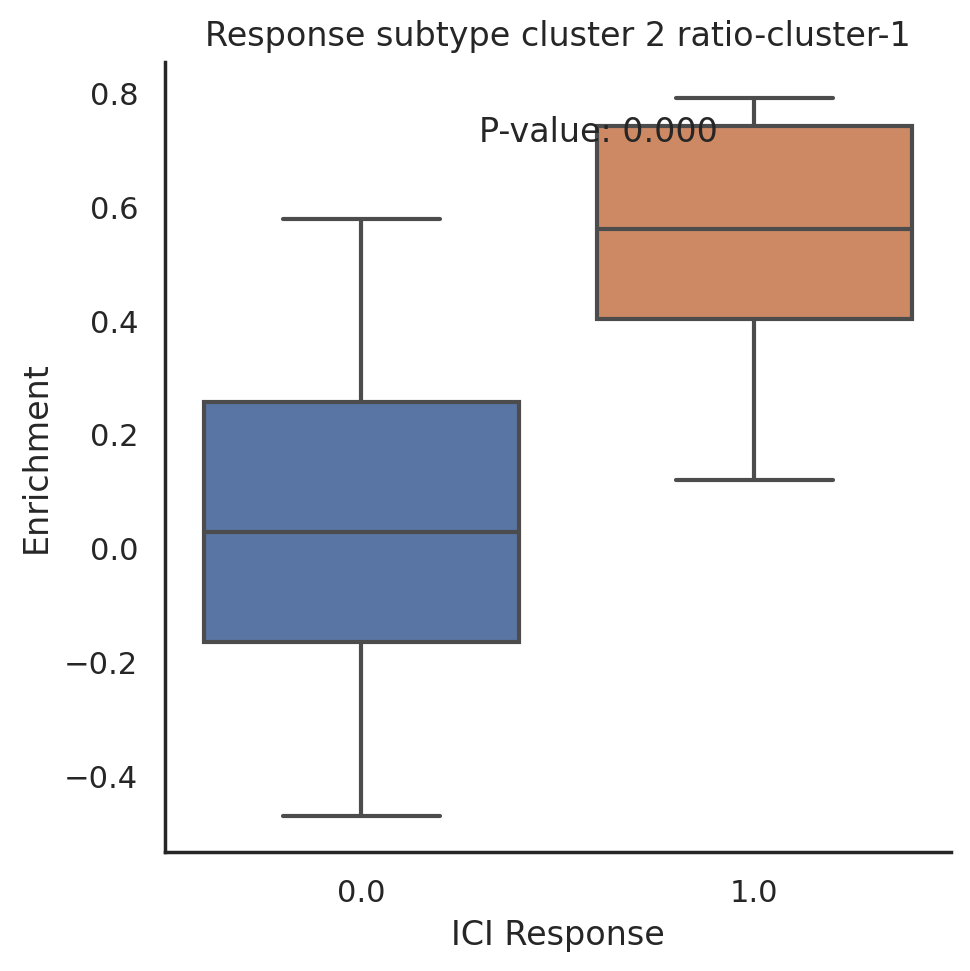

<Figure size 400x400 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

sns.set(style="white")

for response_cluster, rows in response_clusters.groupby(1):
    
    response_enrich = enrich.reindex(rows[0].values)
    resistance_enrich = enrich.reindex(resistant_clusters[0].values)
    
    print(response_cluster)
    
    _name = " ".join(response_cluster.split("-")[2:])
    for cluster in response_enrich.columns:
        
        if not _name in cluster:
            continue
            
        fig, ax = plt.subplots(1, figsize=(5, 5))

        data = pd.DataFrame(index=np.hstack((response_enrich.index.values, resistance_enrich.index.values)))
        
        data.loc[response_enrich.index.values, "label"] = 1
        data.loc[resistance_enrich.index.values, "label"] = 0
        data.loc[response_enrich.index.values, cluster] = response_enrich[cluster].values
        data.loc[resistance_enrich.index.values, cluster] = resistance_enrich[cluster].values
        
        stat, pval = mannwhitneyu(data[data["label"] == 1].iloc[:, 1].values, data[data["label"] == 0].iloc[:, 1].values)

        sns.boxplot(x="label", y=cluster, data=data, ax=ax)
        ax.annotate(f"P-value: {pval:.3f}", xy=(0.4, 0.9), xycoords='axes fraction')

        ax.set_title(" ".join([x.capitalize() for x in cluster.split(]).capitalize())
        ax.set_xlabel("ICI Response")
        ax.set_ylabel("Enrichment")
        
        plt.tight_layout()
        
        sns.despine()  
        plt.savefig(f"../../../../figures/su2c/{response_cluster}-{cluster}-enrichment.png",
                    bbox_inches="tight")
        
        plt.show()
        plt.close()
        plt.clf()
    
    continue
    
    
    # Differential Expression Analysis
    anno = pd.DataFrame(index=np.hstack((response_enrich.index.values, resistance_enrich.index.values)))
    anno.loc[response_enrich.index.values, "label"] = 1.0
    anno.loc[resistance_enrich.index.values, "label"] = 0.0
    
    _counts = counts.reindex(anno.index.values, axis=1)
    _counts = _counts[_counts.sum(axis=1) >= 10]
    
    dds = DeseqDataSet(counts=_counts.T,
                       metadata=anno,
                       design_factors="label",
                       refit_cooks=True,
                       n_cpus=8)
    
    dds.deseq2()
    
    stat_res = DeseqStats(dds, n_cpus=8)

    stat_res.summary()
    
    stat_res.lfc_shrink()
    
    results_df = stat_res.results_df.copy().dropna()

    results_df["symbol"] = results_df.index.map(gmap["external_gene_name"].to_dict()).values
    results_df = results_df.sort_values("pvalue").drop_duplicates("symbol", keep="first").set_index("symbol")
    results_df = results_df.sort_values("stat", ascending=False)
    
    os.makedirs(f"../../../../figures/su2c/subtype/{response_cluster}/focus", exist_ok=True)
    
    with rc_context({'figure.figsize': (5, 5)}):
        dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=10)
        plt.savefig(f"../../../../figures/su2c/subtype/{response_cluster}/{response_cluster}-volcano-plot.png",
                    bbox_inches="tight")
        plt.show()
        plt.close()
        plt.clf()
    
    
    mat = results_df["log2FoldChange"].to_frame().T
    pathway_acts, pathway_pvals = dc.run_consensus(mat=mat, 
                                                   net=progeny)
    with rc_context({'figure.figsize': (5, 5)}):
        dc.plot_barplot(pathway_acts, 'log2FoldChange', top=25, vertical=False)
        plt.savefig(f"../../../../figures/su2c/subtype/{response_cluster}/{response_cluster}-progeny-plot.png", 
                    bbox_inches="tight")
        plt.show()
        plt.close()
        plt.clf()
        
    for sig_prog in pathway_acts.abs().T.sort_values("log2FoldChange").tail(10).index.values:
        with rc_context({'figure.figsize': (5, 5)}):
            dc.plot_targets(results_df, stat='stat', source_name=sig_prog, net=progeny, top=15)
            plt.savefig(f"../../../../figures/su2c/subtype/{response_cluster}/focus/{response_cluster}-progeny-plot-{sig_prog}.png", 
                        bbox_inches="tight")
            plt.show()
            plt.close()
            plt.clf()
            
    # Infer pathway activities with consensus
    tf_acts, tf_pvals = dc.run_consensus(mat=mat, net=dorothea)
    with rc_context({'figure.figsize': (5, 5)}):
        dc.plot_barplot(tf_acts, 'log2FoldChange', top=20, vertical=True)
        plt.savefig(f"../../../../figures/su2c/subtype/{response_cluster}/{response_cluster}-dorothea-plot.png", 
                    bbox_inches="tight")
        plt.show()
        plt.close()
        plt.clf()
        
    for sig_dorth in tf_acts.abs().T.sort_values("log2FoldChange").tail(10).index.values:
        with rc_context({'figure.figsize': (5, 5)}):
            dc.plot_targets(results_df, stat='stat', source_name=sig_dorth, net=dorothea, top=15)
            plt.savefig(f"../../../../figures/su2c/subtype/{response_cluster}/focus/{response_cluster}-dorothea-plot-{sig_dorth}.png", 
                        bbox_inches="tight")
            plt.show()
            plt.close()
            plt.clf()
            
            
    #
    # Infer enrichment with ora using significant deg
    #
    gs_acts, gs_pvals = dc.run_ulm(mat=mat, 
                                   net=msigdb)

    with rc_context({'figure.figsize': (5, 5)}):
        dc.plot_barplot(gs_acts, 'log2FoldChange', top=15, vertical=True)
        plt.savefig(f"../../../../figures/su2c/subtype/{response_cluster}/{response_cluster}-msigdb-plot.png", 
                    bbox_inches="tight")
        plt.show()
        plt.close()
        plt.clf()
        
    for sig_path in gs_acts.abs().T.sort_values("log2FoldChange").tail(10).index.values:
        with rc_context({'figure.figsize': (5, 5)}):
            dc.plot_targets(results_df, stat='stat', source_name=sig_path, net=msigdb, top=15)
            plt.savefig(f"../../../../figures/su2c/subtype/{response_cluster}/focus/{response_cluster}-msigdb-plot-{sig_path}.png", 
                        bbox_inches="tight")
            plt.show()
            plt.close()
            plt.clf()

In [11]:
meta = pd.read_csv("../../../../data/clinical/processed/su2c-rna-clinical.tsv", sep='\t', index_col=5)
meta = meta.reindex(enrich.index)
meta = meta.sort_values(["histology", "line_of_treatment", "bor"])
enrich = enrich.reindex(meta.index)

In [12]:
meta["histology"].unique()

array(['Adeno', 'LC-NE', 'Other', 'Squamous'], dtype=object)

In [13]:
for histology, rows in meta.groupby("histology"):
    print(histology)
    print(rows)

Adeno
                                patient sex histology  stage  \
0                                                              
SU2CLC-MGH-1161-T2      SU2CLC-MGH-1161   M     Adeno    3.0   
SU2CLC-COL-1036-T1      SU2CLC-COL-1036   M     Adeno    4.0   
SU2CLC-MGH-1415-T1      SU2CLC-MGH-1415   F     Adeno    4.0   
SU2CLC-DFC-DF0840-T1  SU2CLC-DFC-DF0840   F     Adeno    3.0   
SU2CLC-COL-1044-T1      SU2CLC-COL-1044   F     Adeno    4.0   
SU2CLC-DFC-DF0109-T1  SU2CLC-DFC-DF0109   M     Adeno    3.0   
SU2CLC-COL-1021-T1      SU2CLC-COL-1021   F     Adeno    NaN   
SU2CLC-MGH-1568-T1      SU2CLC-MGH-1568   F     Adeno    4.0   
SU2CLC-MGH-1501-T1      SU2CLC-MGH-1501   M     Adeno    3.0   
SU2CLC-COL-1017-T1      SU2CLC-COL-1017   M     Adeno    4.0   
SU2CLC-MGH-1412-T1      SU2CLC-MGH-1412   F     Adeno    4.0   
SU2CLC-DFC-1020-T1      SU2CLC-DFC-1020   F     Adeno    3.0   
SU2CLC-CLE-NIVO19-T1  SU2CLC-CLE-NIVO19   F     Adeno    4.0   
SU2CLC-MGH-1574-T1      SU2CLC-MGH

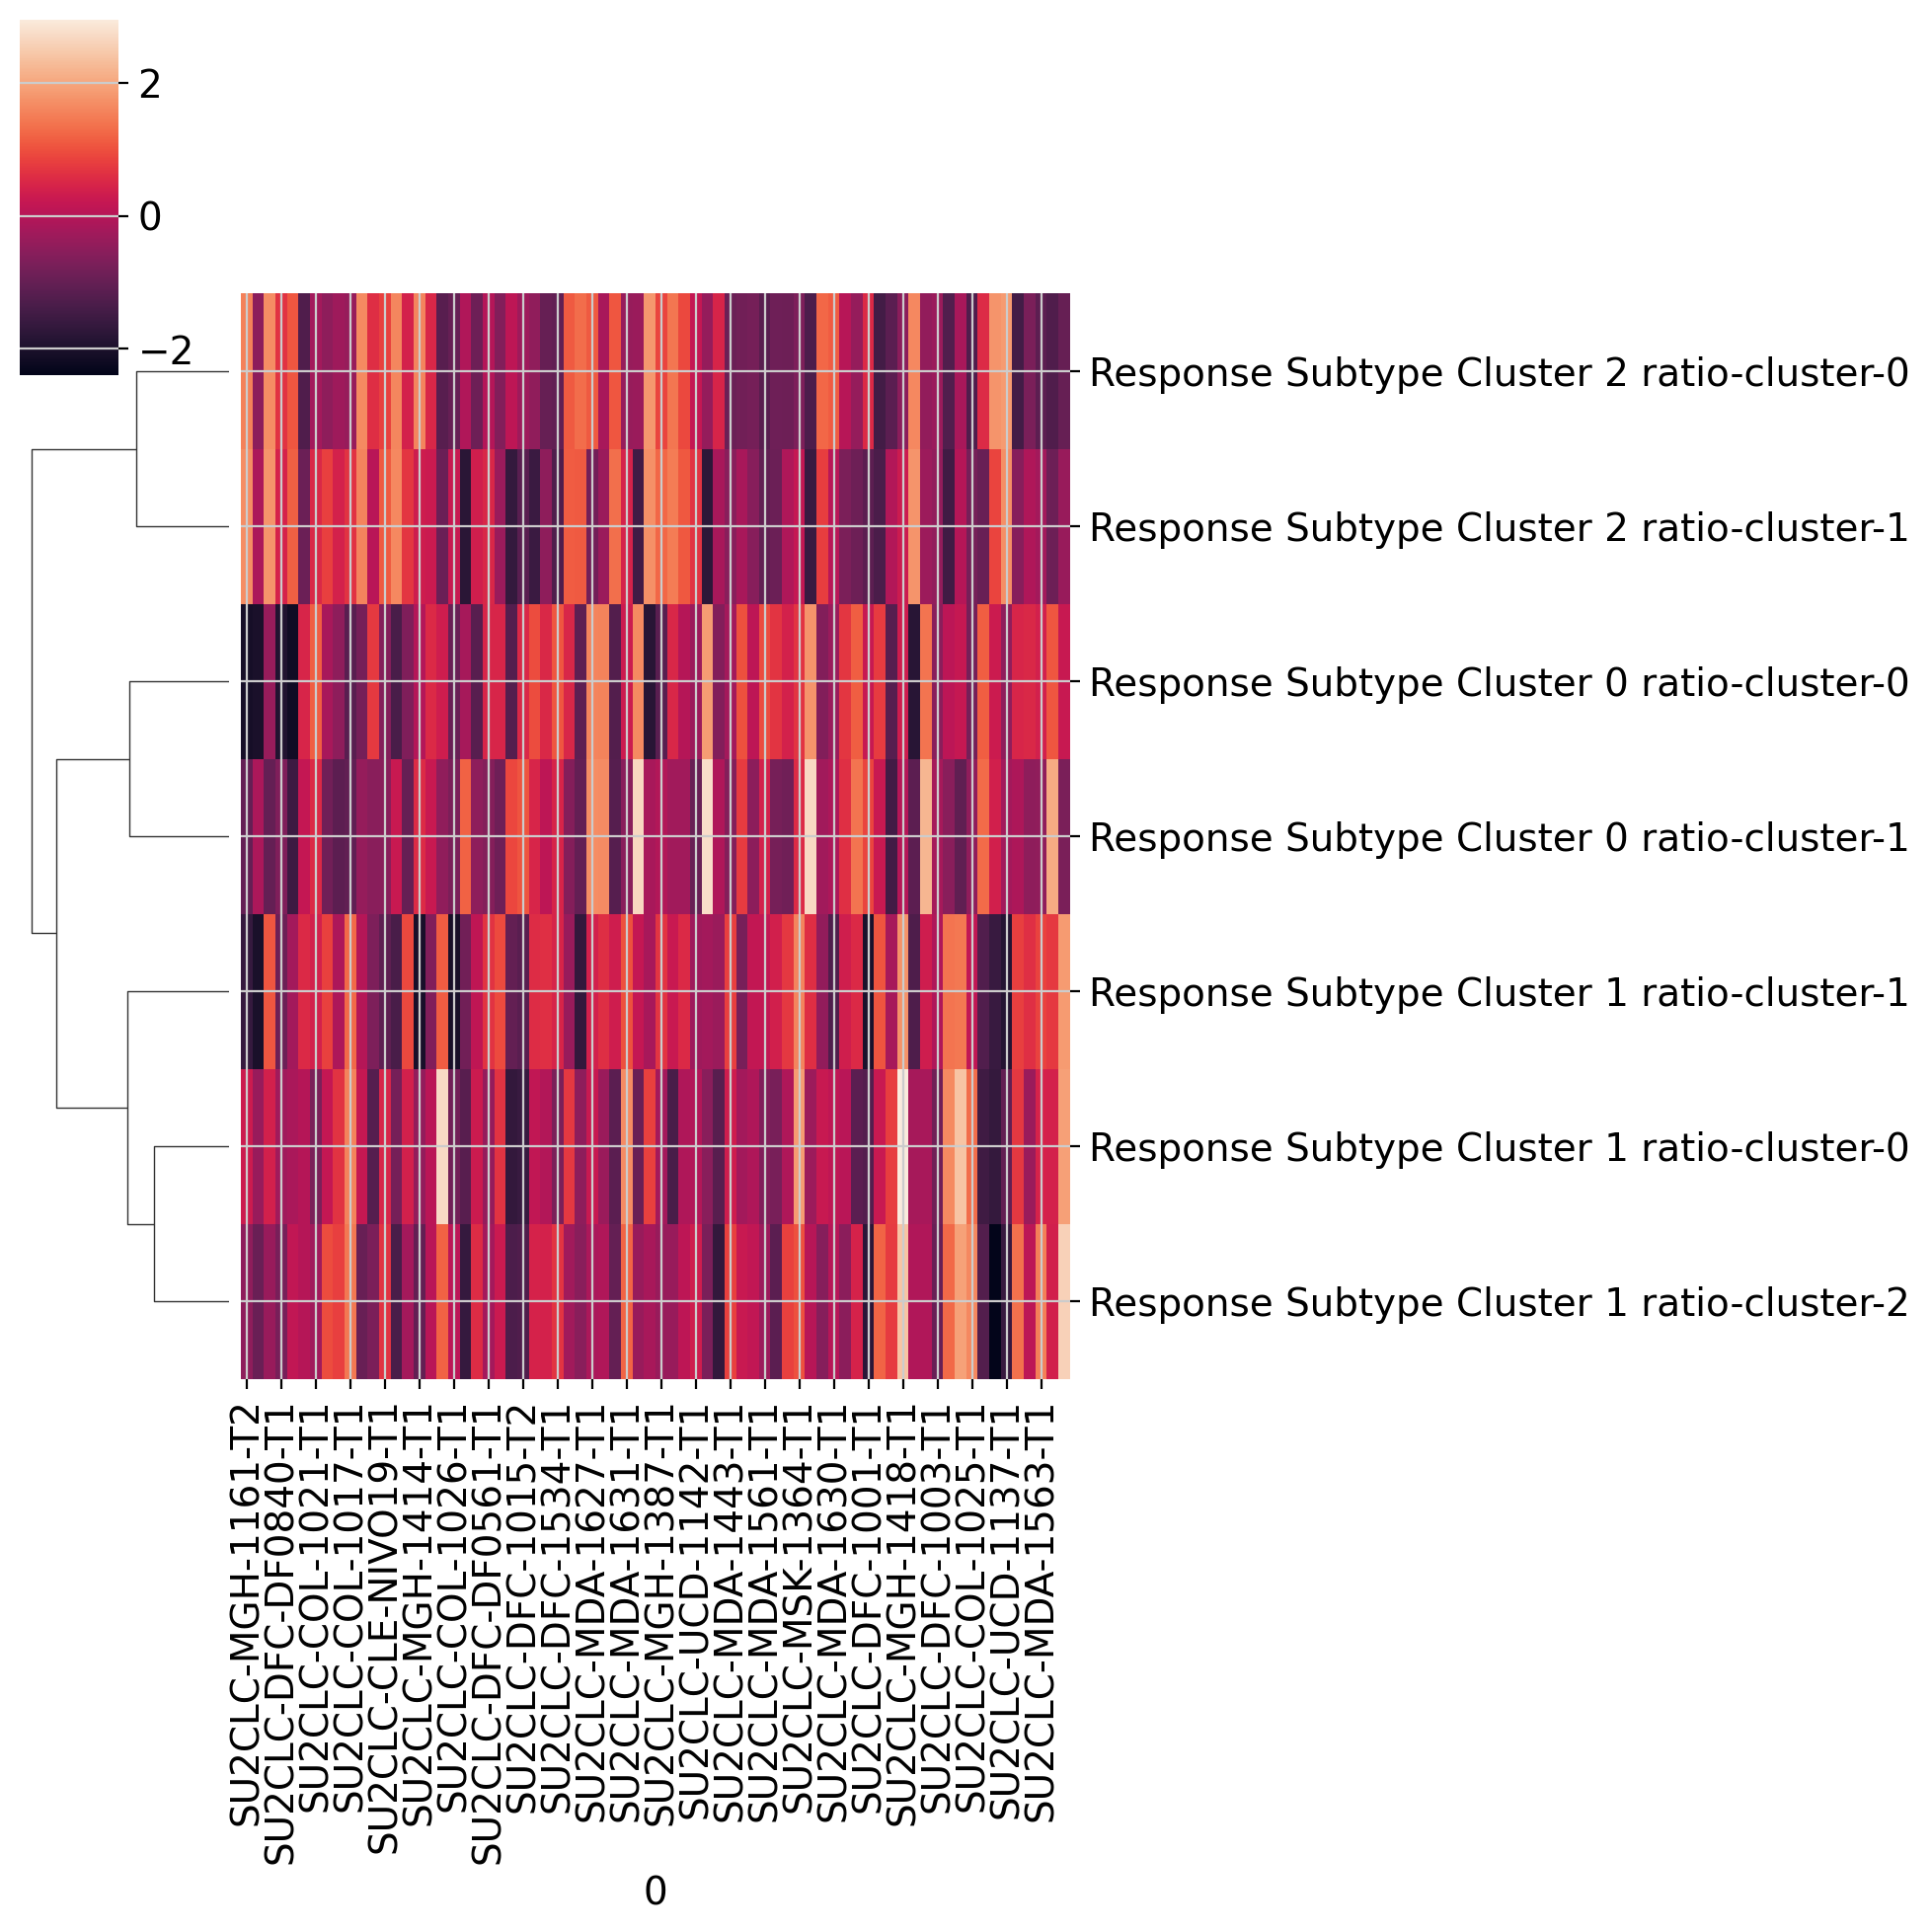

In [14]:
col_annos = []

sns.clustermap(enrich.T, z_score=0, col_cluster=False)